In [1]:
import pandas as pd
import matplotlib.pyplot as plt

# Cargar los datos desde el archivo CSV
file_path = "../data/raw/excel1.csv"
df = pd.read_csv(file_path, sep=',')

# Convertir la columna ID_Date a formato de fecha (YYYY-MM-DD)
df['ID_Date'] = pd.to_datetime(df['ID_Date'], format='%Y%m').dt.strftime('%Y-%m-%d')
# Mostrar el DataFrame
df.head(2)

,ID_Date,Unique_visitors,PDFBrochuresDownloaded,ProductConfigurator,Product_configurator_Visists,SocialNetworks,DirectTraffic,EMail,NaturalSearch,OnlineMedia,OtherReferrer,PaidSearch
0,2022-01-01,272382,4838,33222,94248,1415,65373,25,167199,63649,39808,13798
1,2022-02-01,352581,5823,38570,109531,546,77209,26,176733,124861,45543,28656


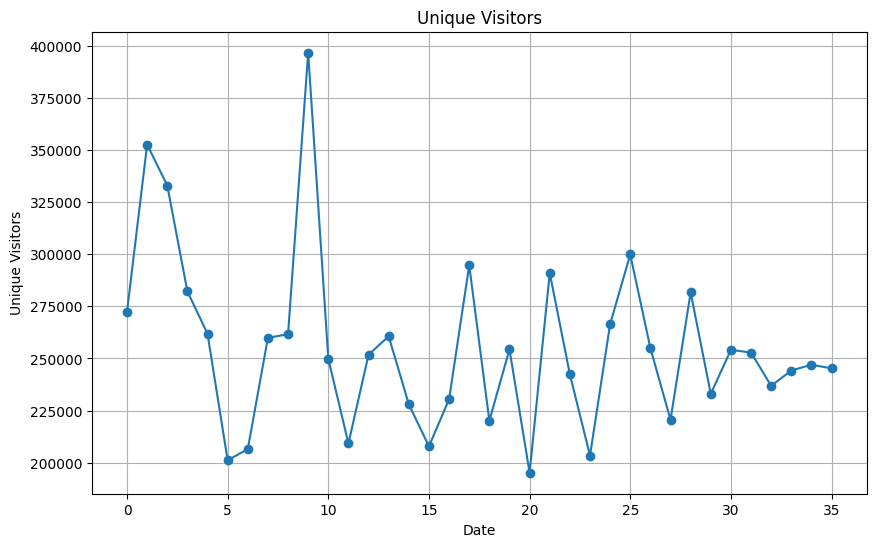

In [2]:
# Graficar la columna 'Revenue'
plt.figure(figsize=(10, 6))
plt.plot(df.index, df['Unique_visitors'], marker='o', linestyle='-')
plt.title('Unique Visitors')
plt.xlabel('Date')
plt.ylabel('Unique Visitors')
plt.grid(True)
plt.show()

In [3]:
import numpy as np
print(np.__version__)

1.23.5


In [ ]:
# Dividir los datos en conjunto de entrenamiento y conjunto de prueba (80% entrenamiento, 20% prueba)
train_size = int(len(df) * 0.8)
train, test = df.iloc[:train_size], df.iloc[train_size:]

# Ajustar el modelo SARIMA automáticamente
import pandas as pd
from pmdarima import auto_arima


In [ ]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Probar modelos cercanos al mejor AIC
candidate_models = [
    (1, 2, 2, 0, 1, 1, 12),  # Mejor modelo (AIC: 176.027)
    (0, 2, 2, 0, 1, 1, 12),  # Probamos sin AR
    (1, 2, 1, 0, 1, 1, 12),  # Probamos con menos MA
    (1, 2, 2, 1, 1, 1, 12),  # Probamos con SAR
]

best_aic = float("inf")
best_model = None

for order in candidate_models:
    try:
        model = SARIMAX(
            y,
            order=(order[0], order[1], order[2]),
            seasonal_order=(order[3], order[4], order[5], order[6]),
            enforce_stationarity=False,
            enforce_invertibility=False
        )
        results = model.fit(disp=False)
        if results.aic < best_aic:
            best_aic = results.aic
            best_model = results
        print(f"SARIMA{order} - AIC:{results.aic}")
    except:
        continue

# Mostrar el mejor modelo encontrado
print("\nMejor modelo encontrado:")
print(f"AIC: {best_aic}")
print(best_model.summary())

SARIMA(0, 0, 0)x(0, 0, 0, 12) - AIC:973.7612696875328
SARIMA(0, 0, 0)x(0, 0, 1, 12) - AIC:871.6149649656481
SARIMA(0, 0, 0)x(0, 1, 0, 12) - AIC:570.9542545410316
SARIMA(0, 0, 0)x(0, 1, 1, 12) - AIC:268.09209942783684
SARIMA(0, 0, 0)x(1, 0, 0, 12) - AIC:590.9193534289545
SARIMA(0, 0, 0)x(1, 0, 1, 12) - AIC:561.3458727947066
SARIMA(0, 0, 0)x(1, 1, 0, 12) - AIC:287.47488628031715
SARIMA(0, 0, 0)x(1, 1, 1, 12) - AIC:269.49285629607687
SARIMA(0, 0, 1)x(0, 0, 0, 12) - AIC:924.5523958772899
SARIMA(0, 0, 1)x(0, 0, 1, 12) - AIC:597.0356212715135
SARIMA(0, 0, 1)x(0, 1, 0, 12) - AIC:541.8345377535636
SARIMA(0, 0, 1)x(0, 1, 1, 12) - AIC:244.43541262195598
SARIMA(0, 0, 1)x(1, 0, 0, 12) - AIC:647.7098783724277
SARIMA(0, 0, 1)x(1, 0, 1, 12) - AIC:596.0684767282562
SARIMA(0, 0, 1)x(1, 1, 0, 12) - AIC:290.92284797547336
SARIMA(0, 0, 1)x(1, 1, 1, 12) - AIC:243.59709789962054
SARIMA(0, 0, 2)x(0, 0, 0, 12) - AIC:894.181699575319
SARIMA(0, 0, 2)x(0, 0, 1, 12) - AIC:571.1460991401523
SARIMA(0, 0, 2)x(0, 1, 